In [ ]:
!pip3 install ACSConv

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd
import PIL
from PIL import Image
import torchvision
import torch
import glob
import nibabel as nib
import time

import torch.nn.functional as F
from torchvision import utils, transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from sklearn.model_selection import KFold
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter


myseed = 1
torch.manual_seed(myseed)
np.random.seed(myseed)

num_classes=2

%matplotlib inline

In [3]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cpu


### 1) Data wrangling

In [4]:
!ls ../../../../fast_storage/ADNI1/

AD  AD_CN_Added_Aug2022  ADNIMERGE_ADNI1.xlsx  CN_F  CN_M  MCI_F  MCI_M


#### Retrieve img filenames and paths

In [5]:
# specifying the zip file name
img_path = "../../../../fast_storage/ADNI1/"
data_dirs = ["AD", "AD_CN_Added_Aug2022", "CN_F", "CN_M"]
file_ext = "*.nii.gz"

imgs_list=[]
for d in data_dirs:
    
    # Retrieve list of all filenames extracted ending with "*.nii.gz"
    img_dir = os.path.join(img_path, d,file_ext)
    imgs_list.extend( list(glob.glob(img_dir)) ) 
    
print(f"Found {len(imgs_list)} images")

Found 426 images


#### Extract subject Id from img filenames

In [6]:
def get_id(images_list=[]):
    
    subj_list=[]
    for file in images_list:
        img_name = os.path.basename(file)
        subject_id = img_name.split(".")[0]
        #print(f"file {file}, img_name={img_name}, subject_id={subject_id}")
        subj_list.append(subject_id)

    return subj_list

subj_list = get_id(imgs_list)

#### Created Dataframe with < subj_id, filepath >

In [7]:
img_df = pd.DataFrame(list(zip(subj_list, imgs_list)), columns=['PTID', 'IMG_PATH'])
img_df.head()
print(f"Final data has {len(img_df)}")

Final data has 426


#### Retrieve ADNIs.csv

In [8]:
img_path = "../../../../fast_storage/ADNI1/" # 2 dirs inside the path, one for 'AD', one for 'CN'

In [9]:
data_path = "../../ADNI_pre-processing/"
filename = "ADNI1_extracted.csv"

labels_col = "DX_bl"

adni = pd.read_csv(os.path.join(data_path, filename))
adni.head()

# Print 
print(f"Final data has {len(adni)}")

print(f"Class distribution is organized as follow:")
print(f"Final:\n {adni[labels_col].value_counts()}")
adni.head()

Final data has 583
Class distribution is organized as follow:
Final:
 CN      229
AD      187
LMCI    167
Name: DX_bl, dtype: int64


,Unnamed: 0,PTID,Ref Date,RID,COLPROT,ORIGPROT,SITE,VISCODE,EXAMDATE,DX_bl,...,FDG_bl,PIB_bl,AV45_bl,FBB_bl,Years_bl,Month_bl,Month,M,update_stamp,ExamDeltaToRef
0,0,002_S_0295,2006-05-09,295,ADNI1,ADNI1,2,bl,2006-05-09,CN,...,NaN,NaN,NaN,NaN,0.0,0.0,0,0,2022-07-19 05:01:42.0,0
1,1,002_S_0413,2006-05-08,413,ADNI1,ADNI1,2,bl,2006-05-08,CN,...,NaN,NaN,NaN,NaN,0.0,0.0,0,0,2022-07-19 05:01:42.0,0
2,2,002_S_0559,2006-06-20,559,ADNI1,ADNI1,2,bl,2006-06-20,CN,...,NaN,NaN,NaN,NaN,0.0,0.0,0,0,2022-07-19 05:01:43.0,0
3,3,002_S_0619,2006-06-20,619,ADNI1,ADNI1,2,bl,2006-06-20,AD,...,NaN,NaN,NaN,NaN,0.0,0.0,0,0,2022-07-19 05:01:43.0,0
4,4,002_S_0685,2006-07-20,685,ADNI1,ADNI1,2,bl,2006-07-20,CN,...,NaN,NaN,NaN,NaN,0.0,0.0,0,0,2022-07-19 05:01:44.0,0


#### Merge csv with subj_images path

In [10]:
adni_imgs = pd.merge( left=img_df, right=adni, how="inner", on="PTID", 
                      suffixes=("_x", "_y"),copy=False, indicator=False, validate="one_to_one")

# Rename "Acq Date column" to "Ref Date" and 'Subject' to PTID to match amerge df
adni_imgs = adni_imgs.rename(columns={'DX_bl': 'labels'})

# Map labels values to numeric (CN=0, AD=1)
adni_imgs['labels'] = np.where(adni_imgs['labels'] == "CN", 0, 1)

# Extract only required columns for IMG_only experiments
adni_imgs = adni_imgs[['PTID','IMG_PATH','labels']]

labels_col='labels'
print(f"Final:\n {adni_imgs[labels_col].value_counts()}")
adni_imgs

Final:
 0    227
1    184
Name: labels, dtype: int64


,PTID,IMG_PATH,labels
0,016_S_1263,../../../../fast_storage/ADNI1/AD/016_S_1263.n...,1
1,128_S_0310,../../../../fast_storage/ADNI1/AD/128_S_0310.n...,1
2,116_S_0370,../../../../fast_storage/ADNI1/AD/116_S_0370.n...,1
3,023_S_0093,../../../../fast_storage/ADNI1/AD/023_S_0093.n...,1
4,036_S_0577,../../../../fast_storage/ADNI1/AD/036_S_0577.n...,1
...,...,...,...
406,014_S_0558,../../../../fast_storage/ADNI1/CN_M/014_S_0558...,0
407,007_S_0070,../../../../fast_storage/ADNI1/CN_M/007_S_0070...,0
408,137_S_0283,../../../../fast_storage/ADNI1/CN_M/137_S_0283...,0
409,037_S_0327,../../../../fast_storage/ADNI1/CN_M/037_S_0327...,0


### 2) Dataset creator

In [11]:
class ImgDataset(Dataset):
    """Tabular and Image dataset."""

    def __init__(self, imgs_df):
        self.images = imgs_df
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        line = self.images.iloc[idx, 0:]
        y = line['labels']

        image = nib.load(line['IMG_PATH'])
        image = image.get_fdata() 
        #image = image[..., :3]
        image = transforms.functional.to_tensor(image)
        image = image.unsqueeze(dim=0)
        
        return image, y

img_data = ImgDataset(imgs_df=adni_imgs)

### Randomize the train, val set generation

In [12]:
train_size = int(0.80 * len(img_data))
val_size = int((len(img_data) - train_size) / 2)
test_size = int(len(img_data) - train_size - val_size) 

# Test set will stay the same for all the folds. TV set will be used to get the train and val set with cross-valid
tv_set, test_set = random_split(img_data, (train_size + val_size, test_size), generator=torch.Generator().manual_seed(0))

### 3. Model: img-only

In [13]:
def get_inplanes():
    return [64, 128, 256, 512]


def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)


def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = conv3x3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = conv1x1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=3,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=400):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv3d(n_input_channels,
                               self.in_planes,
                               kernel_size=(conv1_t_size, 7, 7),
                               stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.FloatTensor):
            zero_pads = zero_pads

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(self._downsample_basic_block,
                                     planes=planes * block.expansion,
                                     stride=stride)
            else:
                downsample = nn.Sequential(
                    conv1x1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def ResNet18(in_channels, num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], in_channels=in_channels, num_classes=num_classes)


def generate_model(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = ResNet(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], get_inplanes(), **kwargs)
    elif model_depth == 152:
        model = ResNet(Bottleneck, [3, 8, 36, 3], get_inplanes(), **kwargs)
    elif model_depth == 200:
        model = ResNet(Bottleneck, [3, 24, 36, 3], get_inplanes(), **kwargs)

    return model

from acsconv.converters import ACSConverter, Conv3dConverter, Conv2_5dConverter

model = generate_model(18, n_input_channels=1,
                 widen_factor=1.0,
                 n_classes=1)
model = model.double()
print(model)
#model = ResNet18(in_channels=91, num_classes=2)
#model = Net(in_channels=n_channels, num_classes=n_classes)
#model = model_to_syncbn(Conv3dConverter(model, i3d_repeat_axis=None))

The ``converters`` are currently experimental. It may not support operations including (but not limited to) Functions in ``torch.nn.functional`` that involved data dimension
ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv3

In [14]:
#img_x, label_x = tv_set[0]
#img_x.shape

#img_x = img_x.unsqueeze(dim=0)
#img_x = img_x.unsqueeze(dim=0)
#output = model(img_x)
#output.shape

#output = model(img_x)
#output.shape

In [15]:
def train(net, loaders, optimizer, criterion, epochs=500, dev=dev, save_param = False, model_name="adni_only-imgs"):
    torch.manual_seed(myseed)
    try:
        net = net.to(dev)
        #print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Store the best val accuracy
        best_val_accuracy = 0

        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                    net.train()
                else:
                    net.eval()
                # Process each batch
                for (images, labels) in loaders[split]:
                    # Move to CUDA
                    images = images.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(images)
                    #pred = pred.squeeze(dim=1) # Output shape is [Batch size, 1], but we want [Batch size]
                    labels = labels.unsqueeze(1)
                    labels = labels.float()
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    #pred_labels = pred.argmax(1) + 1
                    pred_labels = (pred >= 0).long() # Binarize predictions to 0 and 1
                    batch_accuracy = (pred_labels == labels).sum().item()/images.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
                scheduler.step()
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}

            # Store params at the best validation accuracy
            if save_param and epoch_accuracy["val"] > best_val_accuracy:
                #torch.save(net.state_dict(), f"{net.__class__.__name__}_best_val.pth")
                torch.save(net.state_dict(), f"{model_name}_best_val.pth")
                best_val_accuracy = epoch_accuracy["val"]

            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
                
            writer.add_scalar("Train Loss", epoch_loss['train'], epoch)
            writer.add_scalar("Valid Loss", epoch_loss['val'], epoch)
            writer.add_scalar("Test Loss", epoch_loss['test'], epoch)
            writer.add_scalar("Train Accuracy", epoch_accuracy['train'], epoch)
            writer.add_scalar("Valid Accuracy", epoch_accuracy['val'], epoch)
            writer.add_scalar("Test Accuracy", epoch_accuracy['test'], epoch)
            
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},",
                  f"LR={optimizer.param_groups[0]['lr']:.5f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

In [16]:
def reset_weights(m):

    if isinstance(m, nn.Conv3d) or isinstance(m, nn.Linear):
        m.reset_parameters()


------------fold no---------0----------------------
Epoch 1: TrL=0.9133, TrA=0.4580, VL=1.1848, VA=0.6000, TeL=0.6325, TeA=0.6667, LR=0.00040,
Epoch 2: TrL=0.7183, TrA=0.4580, VL=0.7195, VA=0.6375, TeL=0.6324, TeA=0.6667, LR=0.00040,
Epoch 3: TrL=0.7155, TrA=0.5150, VL=0.6887, VA=0.5625, TeL=0.6546, TeA=0.6667, LR=0.00040,
Epoch 4: TrL=0.7015, TrA=0.5188, VL=0.6721, VA=0.6375, TeL=0.6689, TeA=0.6667, LR=0.00040,
Epoch 5: TrL=0.7043, TrA=0.4773, VL=0.6803, VA=0.5875, TeL=0.6604, TeA=0.6458, LR=0.00040,
Epoch 6: TrL=0.6972, TrA=0.5386, VL=0.6834, VA=0.6000, TeL=0.6800, TeA=0.6458, LR=0.00040,
Epoch 7: TrL=0.7050, TrA=0.5347, VL=0.7123, VA=0.6000, TeL=0.6296, TeA=0.6667, LR=0.00040,
Epoch 8: TrL=0.7031, TrA=0.4744, VL=0.7584, VA=0.5875, TeL=0.7274, TeA=0.6458, LR=0.00040,
Epoch 9: TrL=0.7012, TrA=0.5290, VL=0.6817, VA=0.6250, TeL=0.6755, TeA=0.6458, LR=0.00040,
Epoch 10: TrL=0.7051, TrA=0.5087, VL=0.6955, VA=0.6000, TeL=0.6514, TeA=0.6667, LR=0.00040,
Epoch 11: TrL=0.7127, TrA=0.5212, VL=

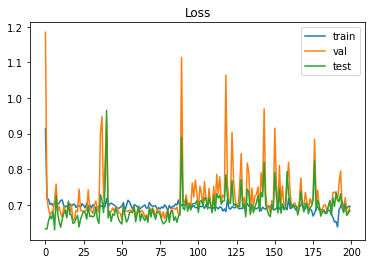

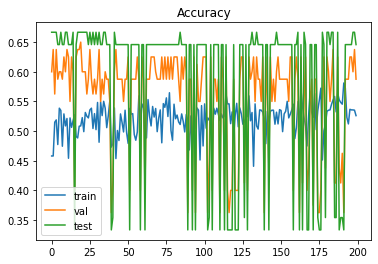

------------fold no---------1----------------------
Epoch 1: TrL=0.7634, TrA=0.4884, VL=0.6912, VA=0.6250, TeL=0.6908, TeA=0.6458, LR=0.00040,
Epoch 2: TrL=0.7020, TrA=0.5425, VL=0.7367, VA=0.5875, TeL=0.7785, TeA=0.6458, LR=0.00040,
Epoch 3: TrL=0.6878, TrA=0.5598, VL=0.7010, VA=0.5750, TeL=0.6753, TeA=0.6667, LR=0.00040,
Epoch 4: TrL=0.6912, TrA=0.5386, VL=0.6927, VA=0.5750, TeL=0.6670, TeA=0.6667, LR=0.00040,
Epoch 5: TrL=0.7052, TrA=0.5077, VL=0.6690, VA=0.6250, TeL=0.6714, TeA=0.6458, LR=0.00040,
Epoch 6: TrL=0.6995, TrA=0.5261, VL=0.6857, VA=0.5875, TeL=0.7070, TeA=0.6458, LR=0.00040,
Epoch 7: TrL=0.7049, TrA=0.5039, VL=0.9518, VA=0.5875, TeL=0.8087, TeA=0.6458, LR=0.00040,
Epoch 8: TrL=0.6948, TrA=0.5396, VL=0.6842, VA=0.6000, TeL=0.6812, TeA=0.6458, LR=0.00040,
Epoch 9: TrL=0.6872, TrA=0.5367, VL=0.7836, VA=0.5875, TeL=0.7411, TeA=0.6458, LR=0.00040,
Epoch 10: TrL=0.7011, TrA=0.5323, VL=0.6844, VA=0.6000, TeL=0.6849, TeA=0.6458, LR=0.00040,
Epoch 11: TrL=0.6985, TrA=0.5314, VL=

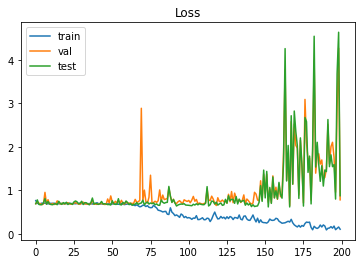

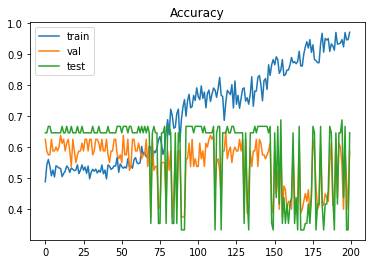

------------fold no---------2----------------------
Epoch 1: TrL=0.9493, TrA=0.4817, VL=0.6940, VA=0.5000, TeL=0.6875, TeA=0.6458, LR=0.00040,
Epoch 2: TrL=0.6966, TrA=0.5526, VL=0.6556, VA=0.5500, TeL=0.6835, TeA=0.6458, LR=0.00040,
Epoch 3: TrL=0.6873, TrA=0.5666, VL=0.6543, VA=0.4750, TeL=0.7095, TeA=0.6458, LR=0.00040,
Epoch 4: TrL=0.6924, TrA=0.5391, VL=0.6470, VA=0.5500, TeL=0.6933, TeA=0.6458, LR=0.00040,
Epoch 5: TrL=0.6875, TrA=0.5516, VL=0.8627, VA=0.4375, TeL=0.6507, TeA=0.6667, LR=0.00040,
Epoch 6: TrL=0.7004, TrA=0.5362, VL=0.6777, VA=0.5500, TeL=0.6691, TeA=0.6458, LR=0.00040,
Epoch 7: TrL=0.6925, TrA=0.5454, VL=0.6461, VA=0.5500, TeL=0.8113, TeA=0.6458, LR=0.00040,
Epoch 8: TrL=0.6966, TrA=0.5478, VL=0.6607, VA=0.4750, TeL=0.8069, TeA=0.6458, LR=0.00040,
Epoch 9: TrL=0.6857, TrA=0.5840, VL=0.6520, VA=0.5125, TeL=0.7189, TeA=0.6458, LR=0.00040,
Epoch 10: TrL=0.6913, TrA=0.5425, VL=0.6570, VA=0.4750, TeL=0.7237, TeA=0.6458, LR=0.00040,
Epoch 11: TrL=0.6907, TrA=0.5555, VL=

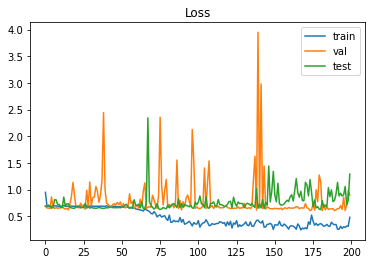

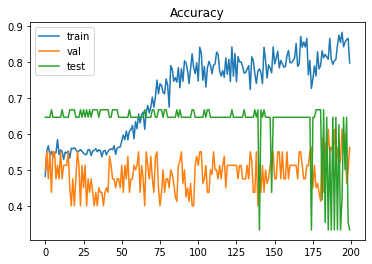

------------fold no---------3----------------------
Epoch 1: TrL=0.7590, TrA=0.5671, VL=0.6942, VA=0.4875, TeL=0.6837, TeA=0.6458, LR=0.00040,
Epoch 2: TrL=0.6916, TrA=0.5594, VL=1.9508, VA=0.4875, TeL=0.6640, TeA=0.6667, LR=0.00040,
Epoch 3: TrL=0.6909, TrA=0.5729, VL=0.9937, VA=0.4500, TeL=0.6621, TeA=0.6667, LR=0.00040,
Epoch 4: TrL=0.6863, TrA=0.5840, VL=1.1894, VA=0.4875, TeL=0.6533, TeA=0.6667, LR=0.00040,
Epoch 5: TrL=0.6978, TrA=0.5666, VL=0.8949, VA=0.4500, TeL=0.6632, TeA=0.6667, LR=0.00040,
Epoch 6: TrL=0.6918, TrA=0.5521, VL=1.1700, VA=0.4500, TeL=0.6547, TeA=0.6667, LR=0.00040,
Epoch 7: TrL=0.6840, TrA=0.5729, VL=1.4273, VA=0.4500, TeL=0.6536, TeA=0.6667, LR=0.00040,
Epoch 8: TrL=0.6838, TrA=0.5681, VL=0.7148, VA=0.4500, TeL=0.6786, TeA=0.6458, LR=0.00040,
Epoch 9: TrL=0.6895, TrA=0.5772, VL=0.7157, VA=0.4750, TeL=0.6718, TeA=0.6458, LR=0.00040,
Epoch 10: TrL=0.6852, TrA=0.5685, VL=0.7197, VA=0.4500, TeL=0.6825, TeA=0.6458, LR=0.00040,
Epoch 11: TrL=0.6798, TrA=0.5772, VL=

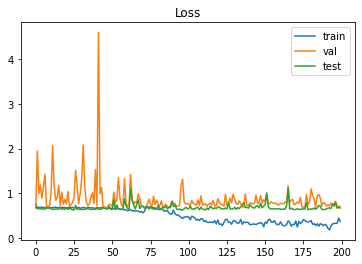

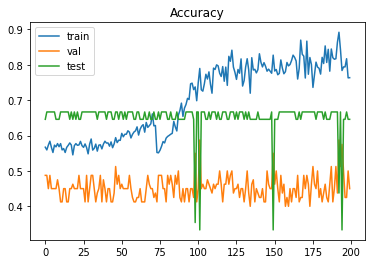

------------fold no---------4----------------------
Epoch 1: TrL=0.7783, TrA=0.4932, VL=0.6907, VA=0.6125, TeL=0.6905, TeA=0.6458, LR=0.00040,
Epoch 2: TrL=0.7183, TrA=0.5000, VL=0.7127, VA=0.5375, TeL=0.6949, TeA=0.6458, LR=0.00040,
Epoch 3: TrL=0.6899, TrA=0.5000, VL=0.8125, VA=0.6250, TeL=0.7194, TeA=0.6458, LR=0.00040,
Epoch 4: TrL=0.6906, TrA=0.5236, VL=0.6930, VA=0.5375, TeL=0.6935, TeA=0.6458, LR=0.00040,
Epoch 5: TrL=0.6944, TrA=0.5270, VL=0.7051, VA=0.6250, TeL=0.7007, TeA=0.6458, LR=0.00040,
Epoch 6: TrL=0.6892, TrA=0.5236, VL=0.7366, VA=0.6250, TeL=0.7159, TeA=0.6458, LR=0.00040,
Epoch 7: TrL=0.6897, TrA=0.5439, VL=0.9292, VA=0.5375, TeL=0.7137, TeA=0.6458, LR=0.00040,
Epoch 8: TrL=0.6907, TrA=0.5405, VL=0.6948, VA=0.6250, TeL=0.6934, TeA=0.6458, LR=0.00040,
Epoch 9: TrL=0.6889, TrA=0.5439, VL=0.7005, VA=0.6250, TeL=0.6942, TeA=0.6458, LR=0.00040,


In [ ]:
generator=torch.Generator()
generator.manual_seed(myseed)
test_loader = DataLoader(test_set,  batch_size=8, num_workers=0, drop_last=False, shuffle=False, generator=generator)

epochs = 200

kfold = KFold(n_splits=5)

for fold,(train_idx,test_idx) in enumerate(kfold.split(tv_set)):
    writer = SummaryWriter("runs/adni_txt-only", filename_suffix=f"_F{fold}_E{epochs}_")
    print('------------fold no---------{}----------------------'.format(fold))
    train_subsampler = SubsetRandomSampler(train_idx)
    test_subsampler = SubsetRandomSampler(test_idx)

    train_loader = DataLoader(tv_set, batch_size=8, drop_last=False, sampler=train_subsampler)
    val_loader = DataLoader(tv_set, batch_size=8, drop_last=False, sampler=test_subsampler)
    
    # Define dictionary of loaders
    loaders = {"train": train_loader,
               "val": val_loader,
               "test": test_loader}

    # Model Params
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)
    # Define a loss 
    criterion = nn.BCEWithLogitsLoss()
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.01, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    
    # Train model
    train(model, loaders, optimizer, criterion, epochs=epochs, dev=dev)
    writer.flush()
    writer.close()
    model.apply(reset_weights)

In [ ]:
x = [8, 91, 91, 109] 
x = x[:, :, None, :, :]

In [ ]:
epoch_time_values

start_time = time.time()
epoch_time_values.append(time.time() - start_time)
#print("Time taken: %.2fs" % (time.time() - start_time))

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

X = np.array([[1, 3], [3, 7], [2, 4], [4, 8]])
y = np.array([0, 1, 0, 1])
stratSplit = StratifiedShuffleSplit(y, n_iter=1, test_size=0.5, random_state=42)
for train_idx, test_idx in stratSplit:
    X_train=X[train_idx]
    y_train=y[train_idx]

print(X_train)
# [[3 7]
#  [2 4]]
print(y_train)
# [1 0]